## AB tests snippets - Bayesian calculations for Conversion rate calculator

In [2]:
import math as mt
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.stats as scs
import matplotlib.ticker as mtick
import seaborn as sns

In [5]:
class Calculations(object):
    def __init__(self, visitors_A, conversions_A, visitors_B, conversions_B, test_duration, percent_traffic_in_test, aov, min_rev_yield):
        self.visitors_A = visitors_A
        self.conversions_A = conversions_A
        self.visitors_B = visitors_B
        self.conversions_B = conversions_B
        self.control_cr = conversions_A / visitors_A
        self.variant_cr = conversions_B / visitors_B
        self.relative_difference = self.variant_cr / self.control_cr - 1
        self.test_duration = test_duration
        self.percent_traffic_in_test = percent_traffic_in_test
        self.min_rev_yield = min_rev_yield
        self.aov = aov
        
    def generate_posterior_samples(self):
        """Creates samples for the posterior distributions for A and B"""

        alpha_prior = 1
        beta_prior = 1

        posterior_A = scs.beta(
            alpha_prior + self.conversions_A,
            beta_prior + self.visitors_A - self.conversions_A,
        )

        posterior_B = scs.beta(
            alpha_prior + self.conversions_B,
            beta_prior + self.visitors_B - self.conversions_B,
        )

        samples = 50000
        self.samples_posterior_A = posterior_A.rvs(samples)
        self.samples_posterior_B = posterior_B.rvs(samples)
        
    def calculate_probabilities(self):
        """Calculate the likelihood that the variants are better"""

        self.prob_A = (self.samples_posterior_A > self.samples_posterior_B).mean()
        self.prob_B = (self.samples_posterior_A <= self.samples_posterior_B).mean()
        
        #relative difference not absolute
        difference = self.samples_posterior_B / self.samples_posterior_A - 1
        self.greater = difference[difference > 0]
        self.lower = difference[difference < 0]
        
        self.mean_positive_difference = 0 if self.greater.size == 0 else self.greater.mean()
        self.mean_negative_difference = 0 if self.lower.size == 0 else self.lower.mean()

        six_months_in_days = 182.5
        visitors_in_six_months = (self.visitors_A + self.visitors_B) / (self.percent_traffic_in_test / 100) / self.test_duration * six_months_in_days
        revenue_in_six_months = visitors_in_six_months * self.control_cr * self.aov 
        
        self.expected_risk = revenue_in_six_months * self.mean_negative_difference
        self.expected_uplift = revenue_in_six_months * self.mean_positive_difference
        min_uplift_prob = self.min_rev_yield / revenue_in_six_months 
        self.prob_yield_mean = (difference >= min_uplift_prob).mean()
        
        self.total_contribution = self.expected_risk * self.prob_A + self.expected_uplift * self.prob_B
        

In [8]:
#b = Calculations(visitors_A, conversions_A, visitors_B, conversions_B, test_duration, traffic_test, aov, min_rev_yield)
bayes = Calculations(5000, 1500, 5000, 1600, 14, 100, 100, 5000)
bayes.generate_posterior_samples()
bayes.calculate_probabilities()
print("CR A:", f"{bayes.control_cr:.2%}", ", CR B:", f"{bayes.variant_cr:.2%}", ", relative difference:", f"{bayes.relative_difference:.2%}") 
print("Chance of being worse", f"{bayes.prob_A:.2%}", "chance of being best", f"{bayes.prob_B:.2%}")
print("Mean negative difference", f"{bayes.mean_negative_difference:.2%}", ", mean positive difference",f"{bayes.mean_positive_difference:.2%}")
print("Expected risk", f"{bayes.expected_risk:,.0f}", ", expected uplift", int(bayes.expected_uplift), ", total contribution", int(bayes.total_contribution))
print("Chance of at least", bayes.min_rev_yield,"in extra revenue:", round(bayes.prob_yield_mean*100,2),"%")


CR A: 30.00% , CR B: 32.00% , relative difference: 6.67%
Chance of being worse 1.54% chance of being best 98.46%
Mean negative difference -1.07% , mean positive difference 6.83%
Expected risk -41,980 , expected uplift 267065 , total contribution 262294
Chance of at least 5000 in extra revenue: 98.3 %


[0.28612416 0.290752   0.30847803 ... 0.29421006 0.28233951 0.29050319]


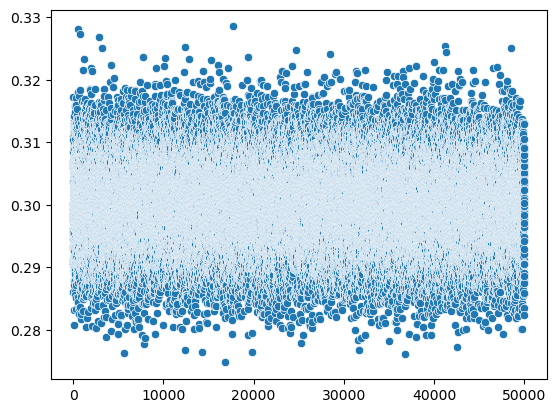

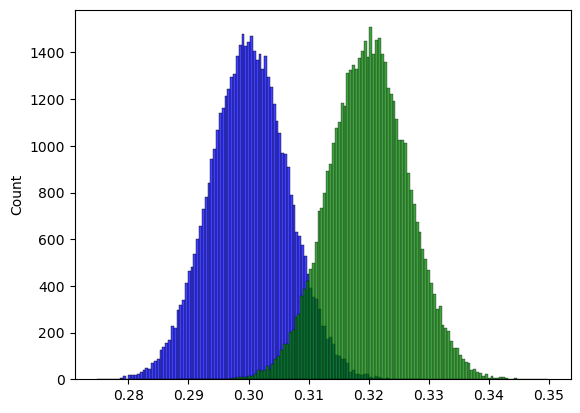

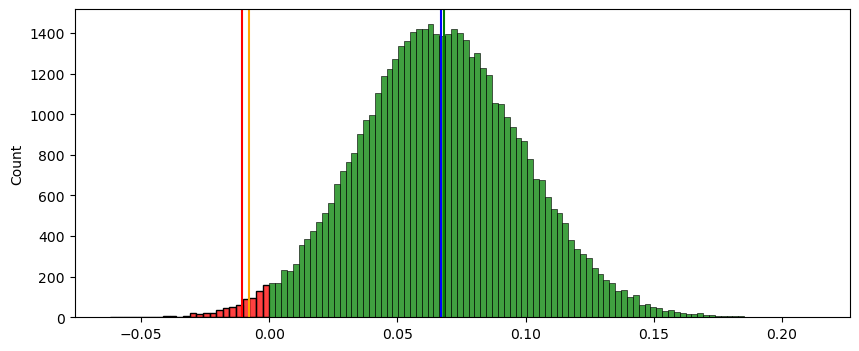

In [9]:
print(bayes.samples_posterior_A)
sns.scatterplot(bayes.samples_posterior_A)
plt.show()

sns.histplot(bayes.samples_posterior_A, color="blue")
sns.histplot(bayes.samples_posterior_B, color="green")
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.patch.set_alpha(0.8)
sns.histplot(bayes.lower, color="red")
sns.histplot(bayes.greater, color="green")
ax.axvline(x = bayes.lower.mean(), color = 'red')
ax.axvline(x = np.median(bayes.lower), color = 'orange')
ax.axvline(x = bayes.greater.mean(), color = 'green')
ax.axvline(x = np.median(bayes.greater), color = 'blue')
plt.show()

In [ ]:
np.median(bayes.lower)
np.mean(bayes.lower)
print(f"{bayes.lower.max():.2%}")
